A DVD rental company needs your help! They want to figure out how many days a customer will rent a DVD for based on some features and has approached you for help. They want you to try out some regression models which will help predict the number of days a customer will rent a DVD for. The company wants a model which yeilds a MSE of 3 or less on a test set. The model you make will help the company become more efficient inventory planning.

The data they provided is in the csv file rental_info.csv. It has the following features:

- "rental_date": The date (and time) the customer rents the DVD.
- "return_date": The date (and time) the customer returns the DVD.
- "amount": The amount paid by the customer for renting the DVD.
- "amount_2": The square of "amount".
- "rental_rate": The rate at which the DVD is rented for.
- "rental_rate_2": The square of "rental_rate".
- "release_year": The year the movie being rented was released.
- "length": Lenght of the movie being rented, in minuites.
- "length_2": The square of "length".
- "replacement_cost": The amount it will cost the company to replace the DVD.
- "special_features": Any special features, for example trailers/deleted scenes that the DVD also has.
- "NC-17", "PG", "PG-13", "R": These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise. For your convinience, the reference dummy has already been dropped.

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('rental_info.csv')

# Convert "return_date" and "rental_date" into datetime format
df["return_date"] = pd.to_datetime(df["return_date"])
df["rental_date"] = pd.to_datetime(df["rental_date"])

# Calculate the number of rental days
df["rental_length"] = df["return_date"] - df["rental_date"]
df["rental_length_days"] = df["rental_length"].dt.days

# Handle missing or invalid data
df["rental_length_days"] = df["rental_length_days"].fillna(df["rental_length_days"].median())
df = df[df["rental_length_days"] >= 0]

In [23]:
# Adding dummy variables using the special features column
special_features_dummies = df["special_features"].str.get_dummies(sep=',')
df = pd.concat([df, special_features_dummies], axis=1)

# Define features and target
features = [
    "amount", "amount_2", "rental_rate", "rental_rate_2", "release_year",
    "length", "length_2", "replacement_cost", "NC-17", "PG", "PG-13", "R"
] + list(special_features_dummies.columns)
X = df[features]
y = df["rental_length_days"]

In [24]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [25]:
# Train and evaluate multiple models
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(alpha=0.1),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    print(f"{name} MSE: {mse}")

# Hyperparameter tuning for RandomForestRegressor
param_dist = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

random_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring="neg_mean_squared_error",
    random_state=42
)

random_search.fit(X_train, y_train)
print("Best parameters for Random Forest:", random_search.best_params_)

Linear Regression MSE: 2.902107252491085
Lasso MSE: 3.064221705853428
Random Forest MSE: 1.95921301216975
Best parameters for Random Forest: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}


In [26]:
# Predicting values on test set
best_rf = random_search.best_estimator_
rf_predictions = best_rf.predict(X_test)

# Computing mean squared error
rf_mse = mean_squared_error(y_test, rf_predictions)
print(f"Random Forest MSE after tuning: {rf_mse}")

Random Forest MSE after tuning: 1.9677391921203822


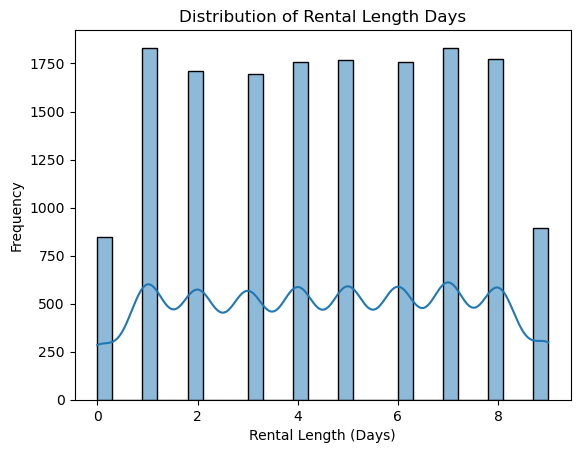

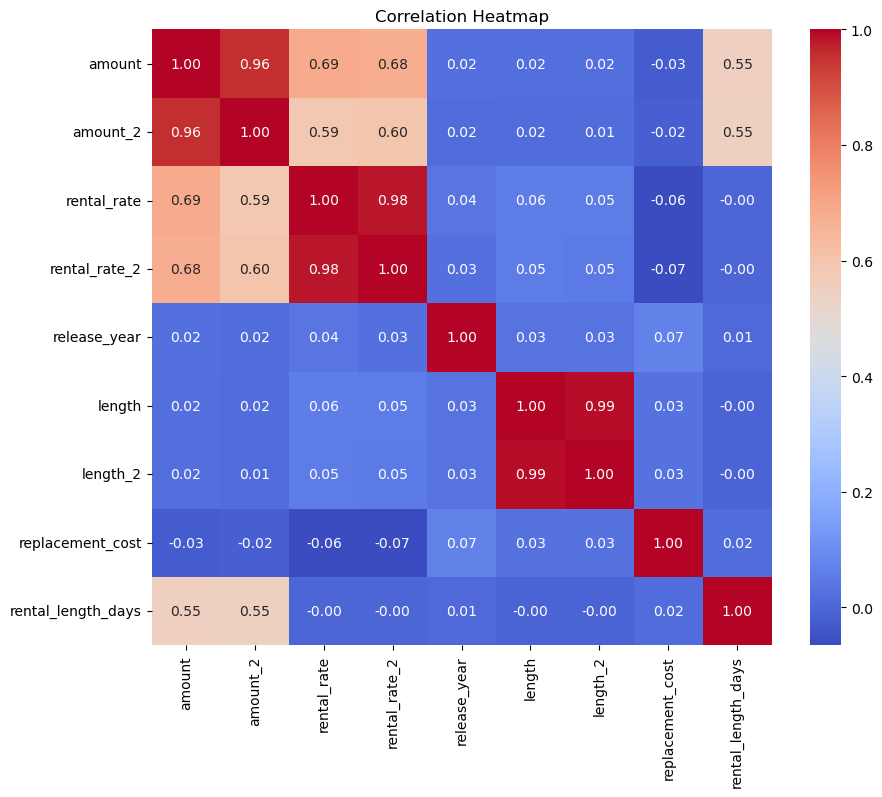

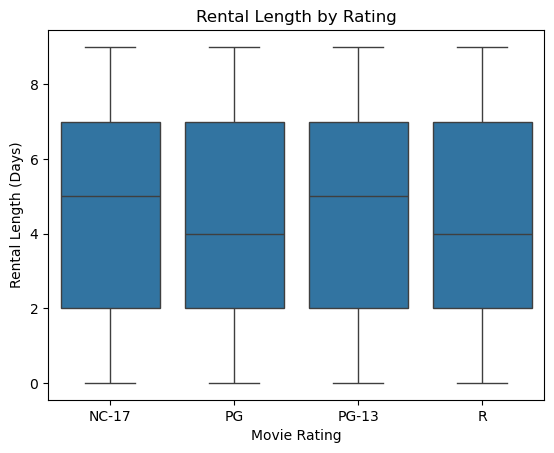

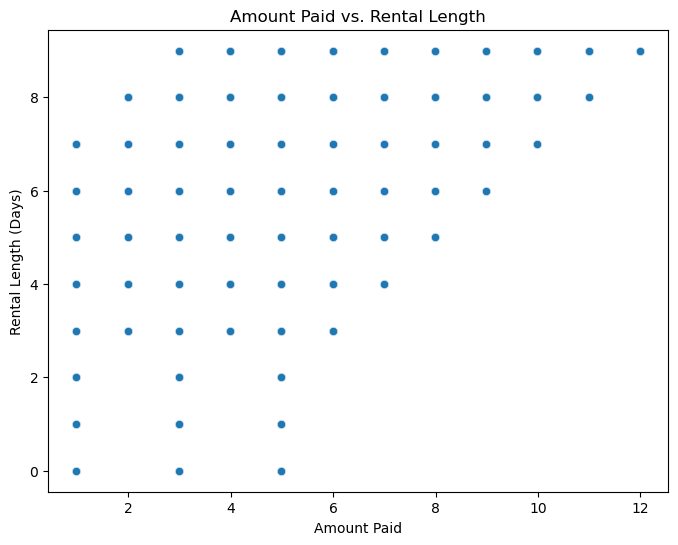

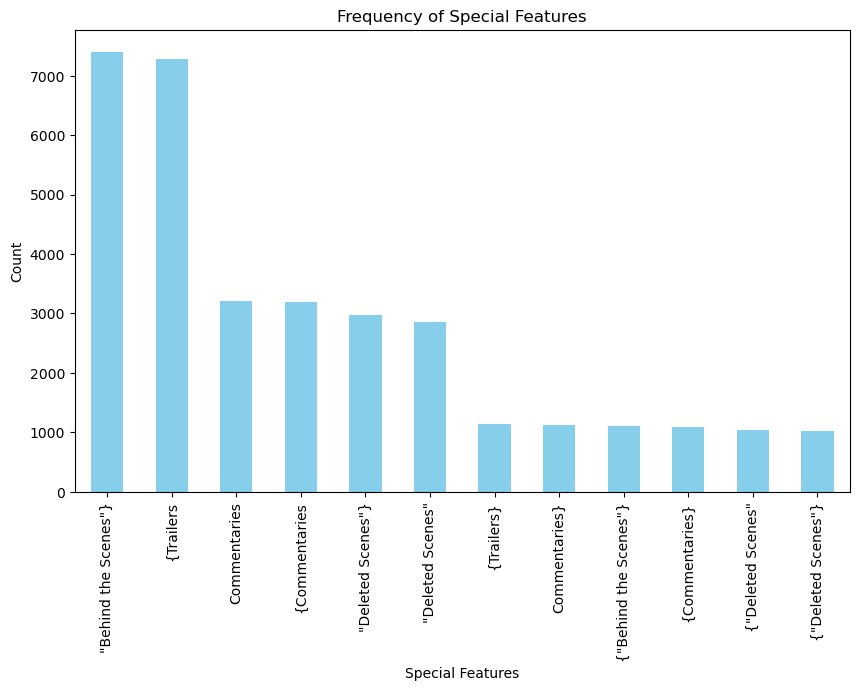

In [27]:
# Visualizations

# 1. Distribution of Rental Length Days
sns.histplot(df["rental_length_days"], bins=30, kde=True)
plt.title("Distribution of Rental Length Days")
plt.xlabel("Rental Length (Days)")
plt.ylabel("Frequency")
plt.show()

# 2. Correlation Heatmap
numerical_features = ["amount", "amount_2", "rental_rate", "rental_rate_2", 
                      "release_year", "length", "length_2", "replacement_cost", "rental_length_days"]
correlation_matrix = df[numerical_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# 3. Boxplot of Rental Length by Rating
ratings = ["NC-17", "PG", "PG-13", "R"]
df_ratings = df[ratings + ["rental_length_days"]].melt(id_vars="rental_length_days", 
                                                       var_name="Rating", 
                                                       value_name="Is_Rated")
df_ratings = df_ratings[df_ratings["Is_Rated"] == 1]

sns.boxplot(data=df_ratings, x="Rating", y="rental_length_days")
plt.title("Rental Length by Rating")
plt.xlabel("Movie Rating")
plt.ylabel("Rental Length (Days)")
plt.show()

# 4. Scatter Plot of Amount vs. Rental Length
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="amount", y="rental_length_days", alpha=0.7)
plt.title("Amount Paid vs. Rental Length")
plt.xlabel("Amount Paid")
plt.ylabel("Rental Length (Days)")
plt.show()

# 5. Bar Plot of Special Features
special_features_counts = special_features_dummies.sum().sort_values(ascending=False)

special_features_counts.plot(kind="bar", figsize=(10, 6), color="skyblue")
plt.title("Frequency of Special Features")
plt.xlabel("Special Features")
plt.ylabel("Count")
plt.show()